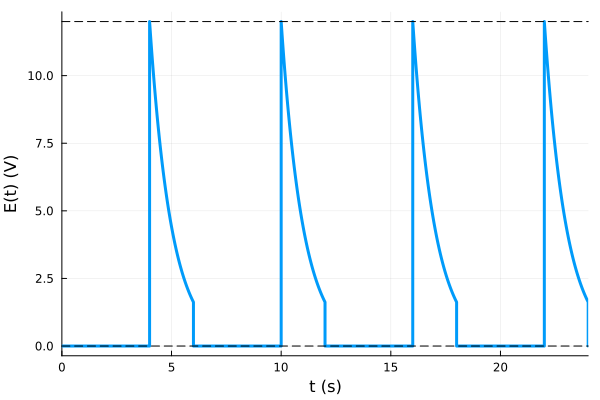

In [1]:
using DifferentialEquations
using Plots

# ----- Parameters -----
R   = 1.0                # Ω
C   = 1.0                # F
E0  = 12.0               # V
t1  = 4.0                # s  (charge: dE/dt = 0)
t2  = 2.0                # s  (discharge: dE/dt = -E/(RC))
T   = t1 + t2
tspan = (0.0, 24.0)

# Start in charging phase
mode = Ref(:charge)

# In-place ODE on a 1-element state vector u = [E]
function heart_voltage!(du, u, p, t)
    du[1] = (mode[] == :charge) ? 0.0 : -u[1]/(R*C)
end

# Times where we switch modes
to_discharge = collect(filter(t -> t ≤ tspan[2], (0:floor(Int,(tspan[2]-t1)/T)) .* T .+ t1))
to_charge    = collect(filter(t -> t ≤ tspan[2], (1:floor(Int,tspan[2]/T)) .* T))

# Callback effects
function start_discharge!(integrator)
    integrator.u[1] = E0        # jump to E0 at the start of discharge
    mode[] = :discharge
end

function start_charge!(integrator)
    integrator.u[1] = 0.0       # reset to 0 at the start of charge
    mode[] = :charge
end

cb_discharge = PresetTimeCallback(to_discharge, start_discharge!;
                                  save_positions=(true,true))
cb_charge    = PresetTimeCallback(to_charge,    start_charge!;
                                  save_positions=(true,true))
callbacks = CallbackSet(cb_discharge, cb_charge)

# Problem + solve
u0 = [0.0]                      # <-- 1-element vector (mutable)
prob = ODEProblem(heart_voltage!, u0, tspan)
sol  = solve(prob, Tsit5(); callback=callbacks, reltol=1e-10, abstol=1e-12)

# Plot E(t)
plot(sol.t, first.(sol.u), lw=3, xlabel="t (s)", ylabel="E(t) (V)",
     legend=false, xlims=tspan)
hline!([0, E0], l=:dash, c=:black, lw=1)